# Deep Learning Assignment - 02 , Set - 5 

## Problem - 01, Group - 029

## Image Captionining

## Library Imports

In [5]:
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from datetime import datetime

import warnings
import os
warnings.simplefilter("ignore")

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Valudate GPU Availability

In [6]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


2021-09-10 10:00:19.649046: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-10 10:00:19.649684: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-10 10:00:19.673147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-10 10:00:19.673580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 40 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.29GiB/s
2021-09-10 10:00:19.673604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-10 10:00:19.674818: I tensorflow/stream_executor/platfo

## Data Visualization and Augmentation

In [7]:
# Read the pickle file

import pickle
with open('../../../LargeDatasets/CNNDatasets/ImageCaptioning/set_0.pkl', 'rb') as f:
    imagelist = pickle.load(f)

In [8]:
# From the pickle list loaded, we will populate a dataframe

imageframe = pd.DataFrame(columns=["CaptionID", "ImageName", "Caption"])

for index in range(len(imagelist)):
    string = imagelist[index]
    splitparts = string.split("\t")
    subparts = splitparts[0].split("#")
    rowDict = {'CaptionID': subparts[1], 'ImageName': subparts[0], 'Caption': splitparts[1]}
    imageframe = imageframe.append(rowDict, ignore_index=True)

# Check the initial rows after dataframe populate
imageframe.head()


,CaptionID,ImageName,Caption
0,4,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .
1,4,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...
2,4,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .
3,0,95734038_2ab5783da7.jpg,A man on a bike nest to a river .
4,1,241346146_f27759296d.jpg,A football player try tackle another player wh...


In [9]:
# Check few unique information from the dataframe

print(f"Number of Unique captionID - {imageframe['CaptionID'].nunique()}")
print(f"Number of Unique Images - {imageframe['ImageName'].nunique()}")

Number of Unique captionID - 5
Number of Unique Images - 8037


In [10]:
# Read the actual images directory

dir_images = '../../../LargeDatasets/CNNDatasets/ImageCaptioning/Flicker8k_Dataset'

images = os.listdir(dir_images)
print(f"Number of images in the directory - {len(images)}")

Number of images in the directory - 8091


### Plotting few images with captions

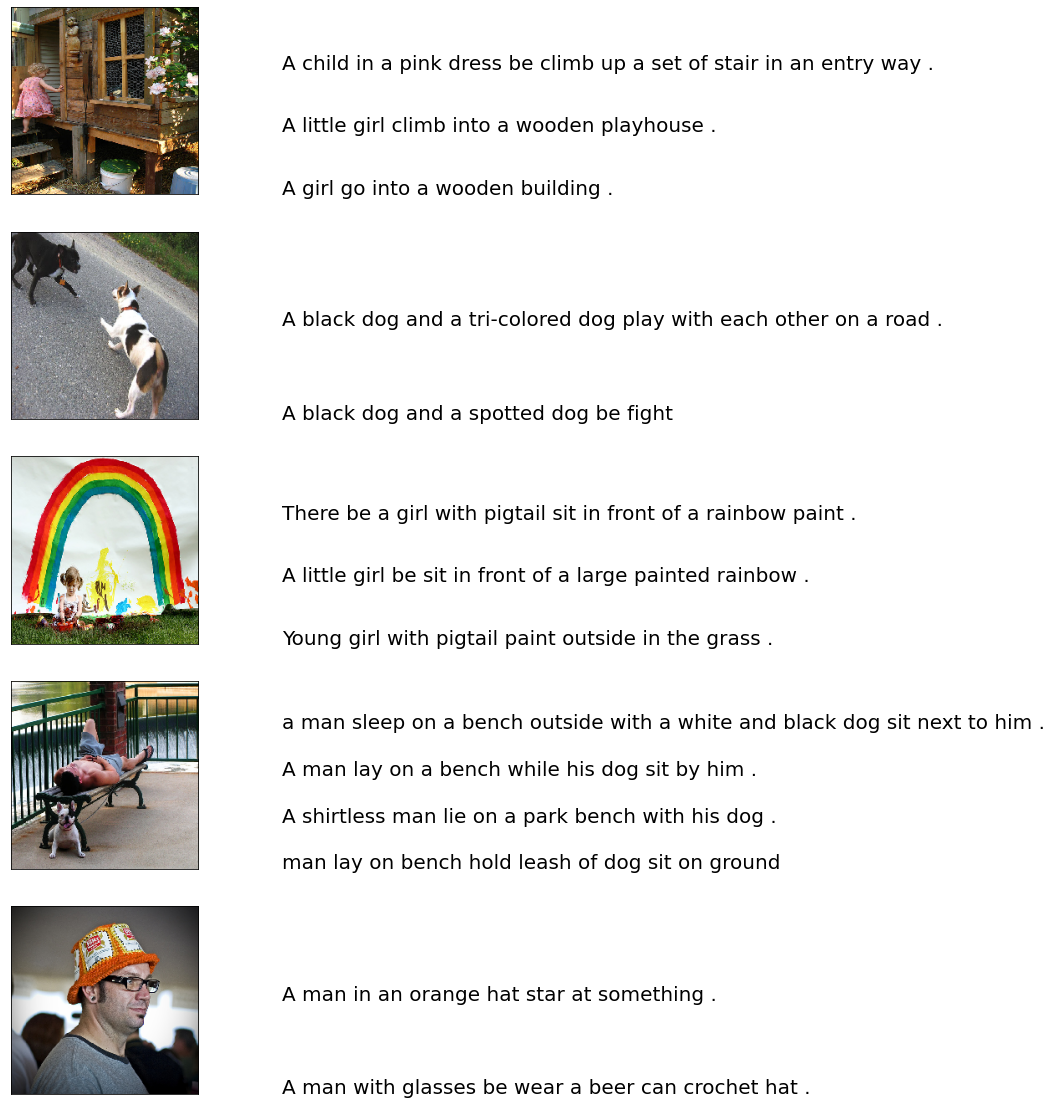

In [13]:
target_size = (225,225,3)

count = 1
fig = plt.figure(figsize=(10,20))

filenames = np.unique(imageframe.ImageName.values)

for item in np.unique(imageframe.ImageName.values)[:5]:
    filename = dir_images + '/' + item
    captions = list(imageframe["Caption"].loc[imageframe["ImageName"] == item].values)
    image_load = tf.keras.preprocessing.image.load_img(filename, target_size=target_size)
        
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [12]:
filenames

array(['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg',
       '1002674143_1b742ab4b8.jpg', ..., '99679241_adc853a5c0.jpg',
       '997338199_7343367d7f.jpg', '997722733_0cb5439472.jpg'],
      dtype=object)